In [1]:
import os as os
import sys as sys
import re as re
import pandas as pd
import numpy as np
import json as json
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pd.options.display.max_columns = 100
pd.options.display.min_rows = None
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 1000

from config import RANDOM_STATE, MATERIALS_PATH, RESULTS_PATH

GENE_SYMBOL_EFFECT_SIZE = MATERIALS_PATH.joinpath(f'D:/ML/bert_dna_weight/data/capstone_body_weight_Statistical_effect_size_analysis_genotype_early_adult_scaled_13022023_gene_symbol_harmonized.pkl')
PROTEIN_SEQUENCE_PATH = MATERIALS_PATH.joinpath(f'D:/ML/bert_dna_weight/data/gene_symbol_protein_sequences.pkl')
EXON_SEQUENCE_PATH = MATERIALS_PATH.joinpath(f'D:/ML/bert_dna_weight/data/gene_symbol_dna_sequence_exon.pkl')
UNSPLICED_SEQUENCE_PATH = MATERIALS_PATH.joinpath(f'D:/ML/bert_dna_weight/data/gene_symbol_dna_sequence_unspliced.pkl')

39


In [2]:
df = pd.read_pickle(GENE_SYMBOL_EFFECT_SIZE)

df = df.groupby(['gene_symbol_harmonized'])[['est_m_ea']].agg('mean')

df = df.reset_index()

# df = df.sample(frac=.25)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit(df[['est_m_ea']].to_numpy())

df['class'] = kmeans.labels_

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_effect_size = df.copy()

print(df.shape)

c:\Users\zeusg\Envs\milestone\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(5497, 3)


In [3]:
df = pd.read_pickle(PROTEIN_SEQUENCE_PATH)

df = df.rename({'seq': 'sequence'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

print(df['class'].value_counts())

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_protein = df.copy()

print(df.shape)

class
0    2937
1    1907
2     573
Name: count, dtype: int64
(5417, 4)


In [16]:
df = pd.read_pickle(EXON_SEQUENCE_PATH)

df = df.rename({'Sequence': 'sequence', 'Gene name': 'gene_symbol_harmonized'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

print(df['class'].value_counts())

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_exon = df.copy()

print(df.shape)

class
0    3029
1    1844
2     606
Name: count, dtype: int64
(5479, 4)


In [17]:
df = pd.read_pickle(UNSPLICED_SEQUENCE_PATH)

df = df.rename({'Sequence': 'sequence', 'Gene name': 'gene_symbol_harmonized'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

print(df['class'].value_counts())

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_unspliced = df.copy()

print(df.shape)

class
0    3029
1    1844
2     606
Name: count, dtype: int64
(5479, 4)


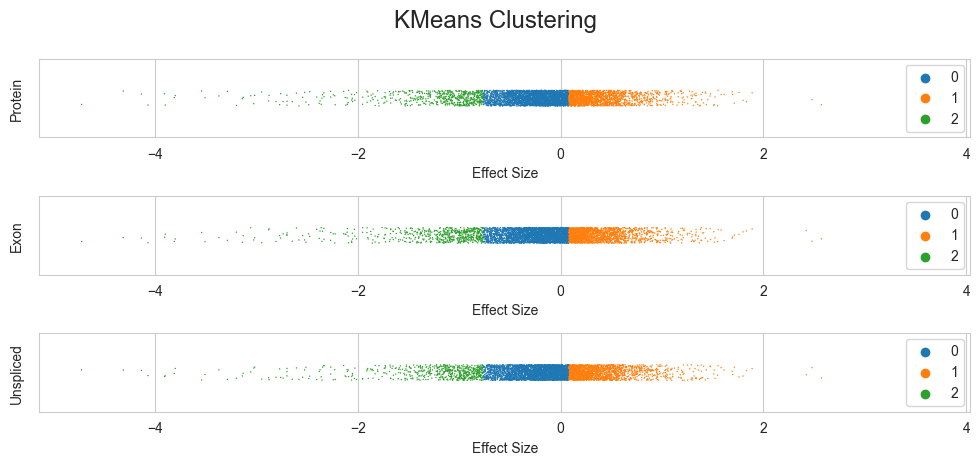

In [18]:
df = _df_protein.copy()

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Protein'] = ''

_df_protein_strip_plot = df.copy()



df = _df_exon.copy()

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Exon'] = ''

_df_exon_strip_plot = df.copy()



df = _df_unspliced.copy()

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Unspliced'] = ''

_df_unspliced_strip_plot = df.copy()



sns.set_style('whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

fig.suptitle('KMeans Clustering', fontsize='xx-large')
fig.set_size_inches((10,4.5))
fig.tight_layout()

_ = sns.stripplot(data=_df_protein_strip_plot, x='Effect Size', y='Protein', hue="Class", marker='.', jitter=True, s=2, ax=ax1, palette='tab10')
_= ax1.legend(loc='right')
_ = sns.stripplot(data=_df_exon_strip_plot, x='Effect Size', y='Exon', hue="Class", marker='.', jitter=True, s=2,  ax=ax2, palette='tab10')
_= ax2.legend(loc='right')
_ = sns.stripplot(data=_df_unspliced_strip_plot, x='Effect Size', y='Unspliced', hue="Class", marker='.', jitter=True, s=2,  ax=ax3, palette='tab10')
_= ax3.legend(loc='right')

plt.subplots_adjust(wspace=0.3, hspace=0.75)
plt.savefig(RESULTS_PATH.joinpath(f'kmeans_clustering_{RANDOM_STATE}.png'), bbox_inches='tight')

In [19]:
def feature_density(df, ngram_range):

    tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=ngram_range)

    X = tfidf.fit_transform(df['sequence'].tolist())

    X = X.todense()

    df = pd.DataFrame(X, columns=tfidf.get_feature_names_out())

    df = df.T.copy()

    kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit(df.to_numpy())

    df['Class'] = kmeans.labels_

    print(pd.Series(kmeans.labels_).value_counts())

    df = df.groupby(['Class']).apply(lambda x: ((x != 0).sum().sum()/(x.shape[0] * x.shape[1]), x.index.tolist())).to_frame(name='density_features').reset_index()

    df['Density'] = df.apply(lambda x: x['density_features'][0], axis=1)

    df['Features'] = df.apply(lambda x: x['density_features'][1], axis=1)

    df['Count'] = df['Features'].apply(lambda x: len(x))

    df = df.drop(['density_features'], axis=1)

    return df.copy()

In [20]:
_df_protein_features = feature_density(df=_df_protein.copy(), ngram_range=(4,4))

MemoryError: Unable to allocate 6.74 GiB for an array with shape (166950, 5417) and data type float64

In [14]:
_df_exon_features = feature_density(df=_df_exon.copy(), ngram_range=(10,10))

MemoryError: Unable to allocate 46.9 GiB for an array with shape (5479, 1147910) and data type float64

In [ ]:
_df_unspliced_features = feature_density(df=_df_unspliced.sample(frac=.1, random_state=RANDOM_STATE).copy(), ngram_range=(12,12))

In [ ]:
sns.set_style('white')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

fig.suptitle('Feature Density Analysis', fontsize='xx-large')
fig.set_size_inches((20,5))
fig.subplots_adjust(top=.85)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

sns.barplot(data=_df_protein_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax1, palette='tab10')
ax1.set_yscale("log")
ax1.set_title('Protein Feature Density')
ax1_twin = ax1.twinx()
sns.scatterplot(data=_df_protein_features, x='Class', y='Density', marker='d', label='Density', color = 'red', s=150, ax=ax1_twin, palette='tab10')
_= ax1_twin.legend(loc='upper right')

sns.barplot(data=_df_exon_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax2, palette='tab10')
ax2.set_yscale("log")
ax2.set_title('Exon Feature Density')
ax2_twin = ax2.twinx()
sns.scatterplot(data=_df_exon_features, x='Class', y='Density', marker='d', label='Density', color = 'red', s=150, ax=ax2_twin, palette='tab10')
_= ax2_twin.legend(loc='upper right')

sns.barplot(data=_df_unspliced_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax3, palette='tab10')
ax3.set_yscale("log")
ax3.set_title('Unspliced Feature Density')
ax3_twin = ax3.twinx()
sns.scatterplot(data=_df_unspliced_features, x='Class', y='Density', marker='d', label='Density', color = 'red', s=150, ax=ax3_twin, palette='tab10')
_= ax3_twin.legend(loc='upper right')

plt.savefig(RESULTS_PATH.joinpath(f'feature_density_analysis_{RANDOM_STATE}.png'), bbox_inches='tight')

In [65]:
def process(df, ngram_range, vocabulary):

    dfs = []

    X = df['sequence'].to_numpy()
    y = df['class'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)




    # KNeighborsClassifier
    param_grid = {
    'tfidfVectorizer__ngram_range': [ngram_range],
    'tfidfVectorizer__norm': ('l1', 'l2'),
    'kNeighborsClassifier__n_neighbors': [3, 5, 9]
    }
    
    knn = {"classifier": KNeighborsClassifier(),
           "name":"knn",
           "param_grid":{
            'tfidfVectorizer__ngram_range': [ngram_range],
            'tfidfVectorizer__norm': ['l1'],
            'kNeighborsClassifier__n_neighbors': [3, 5, 9]
           }}

    pipe = Pipeline(steps=[
        ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb', vocabulary=vocabulary)),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('kNeighborsClassifier', knn["classifier"])
        ])

    kNeighborsClassifier = GridSearchCV(estimator=pipe, param_grid=knn["param_grid"], n_jobs=5, verbose=3)

    kNeighborsClassifier.fit(X_train, y_train)

    accuracy_score = kNeighborsClassifier.score(X_test, y_test)

    df = pd.DataFrame({
        'classifier': 'KNeighborsClassifier',
        'best_params_': [kNeighborsClassifier.best_params_],
        'best_score_': kNeighborsClassifier.best_score_,
        'test_score': accuracy_score
    })

    dfs.append(df)




    # SVC
    param_grid = {
        'tfidfVectorizer__ngram_range': [ngram_range],
        'tfidfVectorizer__norm': ('l1', 'l2'),
        'SVC__kernel': ['linear', 'rbf'],
        'SVC__C': [0.001,0.01,0.1,1,10,100, 1000],
        'SVC__gamma': ['scale', 'auto']
    }

    pipe = Pipeline(steps=[
        ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb', vocabulary=vocabulary)),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('SVC', SVC())
        ])

    gsSVC = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=5, verbose=3)

    gsSVC.fit(X_train, y_train)

    accuracy_score = gsSVC.score(X_test, y_test)

    df = pd.DataFrame({
        'classifier': 'SVC',
        'best_params_': [gsSVC.best_params_],
        'best_score_': gsSVC.best_score_,
        'test_score': accuracy_score
    })
    
    dfs.append(df)




    # LogisticRegression
    param_grid = {
    'tfidfVectorizer__ngram_range': [ngram_range],
    'tfidfVectorizer__norm': ('l1', 'l2'),
    'logisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }

    pipe = Pipeline(steps=[
        ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb', vocabulary=vocabulary)),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('logisticRegression', LogisticRegression())
        ])

    gsLogisticRegression = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=5, verbose=3)

    gsLogisticRegression.fit(X_train, y_train)

    accuracy_score = gsLogisticRegression.score(X_test, y_test)

    df = pd.DataFrame({
        'classifier': 'LogisticRegression',
        'best_params_': [gsLogisticRegression.best_params_],
        'best_score_': gsLogisticRegression.best_score_,
        'test_score': accuracy_score
    })

    dfs.append(df)




    # DummyClassifier
    param_grid = {
        'tfidfVectorizer__ngram_range': [ngram_range],
        'dummyClassifier__strategy': ['uniform', 'most_frequent']
    }

    pipe = Pipeline(steps=[
        ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb', vocabulary=vocabulary)), 
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('dummyClassifier', DummyClassifier())
        ])

    gsDummyClassifier = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=5, verbose=3)

    gsDummyClassifier.fit(X_train, y_train)

    accuracy_score = gsDummyClassifier.score(X_test, y_test)

    df = pd.DataFrame({
        'classifier': 'DummyClassifier',
        'best_params_': [gsDummyClassifier.best_params_],
        'best_score_': gsDummyClassifier.best_score_,
        'test_score': accuracy_score
    })

    dfs.append(df)




    df = pd.concat(dfs)

    df = df.set_index(['classifier']).reset_index()

    return df.copy()

In [66]:
df = _df_protein_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

protein_vocabulary = df['Features'].sum()

df = _df_protein.copy()

df = process(df.sample(frac=.1), (4,4), vocabulary=protein_vocabulary)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [67]:
def process_classifier(classifier_dict, dfs,  data_split, vocabulary):
    
    pipe = Pipeline(steps=[
                     ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb', vocabulary=vocabulary)),
                     ('smote', SMOTE(random_state=RANDOM_STATE)),
                     (classifier_dict['name'], classifier_dict["classifier"])
              ])
    

    X_train, X_test, y_train, y_test = data_split

    
    classifier = GridSearchCV(estimator=pipe, param_grid=classifier_dict["param_grid"], n_jobs=5, verbose=3)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy_score = classifier.score(X_test, y_test)

    df = pd.DataFrame({
        'classifier': classifier_dict["name"],
        'best_params_': [classifier.best_params_],
        'best_score_': classifier.best_score_,
        'test_score': accuracy_score
    })
    dfs.append(df)
    
    plt.figure(figsize=(10,6))
    fx=sns.heatmap(conf_matrix, annot=True, fmt=".2f",cmap="GnBu")
    fx.set_title(f'{classifier_dict["name"]} \n')
    fx.set_xlabel('\n Predicted Values\n')
    fx.set_ylabel('Actual Values\n')
    fx.xaxis.set_ticklabels(['0','1','2'])
    fx.yaxis.set_ticklabels(['0','1','2'])
    plt.show()

    
    return dfs
    

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB



def process(df, ngram_range, vocabulary):
    dfs = []

    X = df['sequence'].to_numpy()
    y = df['class'].to_numpy()

    data_split = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
    
    
    knn = {"classifier": KNeighborsClassifier(),
           "name":"knn",
           "param_grid":{
            'tfidfVectorizer__ngram_range': [ngram_range],
            'tfidfVectorizer__norm': ['l1'],
            'kNeighborsClassifier__n_neighbors': [3, 5, 9]
           }}
    svc = {"classifier": SVC(),
           "name":"svc",
           "param_grid":{
            'tfidfVectorizer__ngram_range': [ngram_range],
            'tfidfVectorizer__norm': ('l1', 'l2'),

           }}
    gpc = {"classifier": GaussianProcessClassifier(),
           "name":"gpc",
           "param_grid":{
            'tfidfVectorizer__ngram_range': [ngram_range],
            'tfidfVectorizer__norm': ['l1'],
           }}
    
    tree = {"classifier": DecisionTreeClassifier(),
           "name":"tree",
           "param_grid":{
            'tfidfVectorizer__ngram_range': [ngram_range],
            'tfidfVectorizer__norm': ['l1'],
           }}
    forest = {"classifier": RandomForestClassifier(),
           "name":"forest",
           "param_grid":{
            'tfidfVectorizer__ngram_range': [ngram_range],
            'tfidfVectorizer__norm': ['l1'],
            'RandomForestClassifier__n_estimators':[100,200,500]
           }}
    
    ada = {"classifier": AdaBoostClassifier(),
           "name":"ada",
           "param_grid":{
            'tfidfVectorizer__ngram_range': [ngram_range],
            'tfidfVectorizer__norm': ['l1'],
           }}
    
    dummy = {"classifier": DummyClassifier(),
           "name":"dummy",
           "param_grid":{
            'tfidfVectorizer__ngram_range': [ngram_range],
            'tfidfVectorizer__norm': ['l1'],
           }}
    
    classifiers = [knn, svc, dummy,tree,forest, ada]
    
    for classifier in classifiers:
           dfs = process_classifier(classifier, dfs,  data_split, vocabulary)

    return pd.concat(dfs)



    
    
    

In [70]:
df = _df_protein_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

protein_vocabulary = df['Features'].sum()

df = _df_protein.copy()

df = process(df.sample(frac=.1), (4,4), vocabulary=protein_vocabulary)

#df.to_pickle(RESULTS_PATH.joinpath(f'classification_protein_{RANDOM_STATE}.pkl'))


Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [52]:
df

,classifier,best_params_,best_score_,test_score
0,knn,"{'tfidfVectorizer__ngram_range': (4, 4), 'tfidfVectorizer__norm': 'l1'}",0.154217,0.118081
0,svc,"{'tfidfVectorizer__ngram_range': (4, 4), 'tfidfVectorizer__norm': 'l1'}",0.547090,0.603321
0,dummy,"{'tfidfVectorizer__ngram_range': (4, 4), 'tfidfVectorizer__norm': 'l1'}",0.547554,0.607011
0,tree,"{'tfidfVectorizer__ngram_range': (4, 4), 'tfidfVectorizer__norm': 'l1'}",0.421527,0.413284
0,forest,"{'tfidfVectorizer__ngram_range': (4, 4), 'tfidfVectorizer__norm': 'l1'}",0.530920,0.557196
0,ada,"{'tfidfVectorizer__ngram_range': (4, 4), 'tfidfVectorizer__norm': 'l1'}",0.510614,0.557196


In [ ]:
df = _df_exon_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

exon_vocabulary = df['Features'].sum()

df = _df_exon.copy()

df = process(df, (10,10), vocabulary=exon_vocabulary)

df.to_pickle(RESULTS_PATH.joinpath(f'classification_exon_{RANDOM_STATE}.pkl'))

In [ ]:
df = _df_unspliced_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

unspliced_vocabulary = df['Features'].sum()

df = _df_exon.copy()

df = _df_unspliced.copy()

df = process(df, (12,12), vocabulary=unspliced_vocabulary)

df.to_pickle(RESULTS_PATH.joinpath(f'classification_unspliced_{RANDOM_STATE}.pkl'))